# Estimating phase-amplitude coupling in simulated data

#### This notebook simulates a neural population that is biased to fire at a preferred phase in a low-frequency oscillation. A local field potential (LFP) is then calculated, and four metrics of PAC are applied to the simulated LFP

Imports

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from NeuroTools import stgen
from pacpy.pac import plv, mi_tort, mi_canolty, glm

C:\Python27\lib\site-packages\matplotlib\__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
C:\Python27\lib\site-packages\NeuroTools\__init__.py:130: DependencyWarning: ** interval ** package is not installed.
To have functions using interval please install the package.
website : http://pypi.python.org/pypi/interval/1.0.0

  warnings.warn(get_import_warning(name), DependencyWarning)


Simulate spike trains

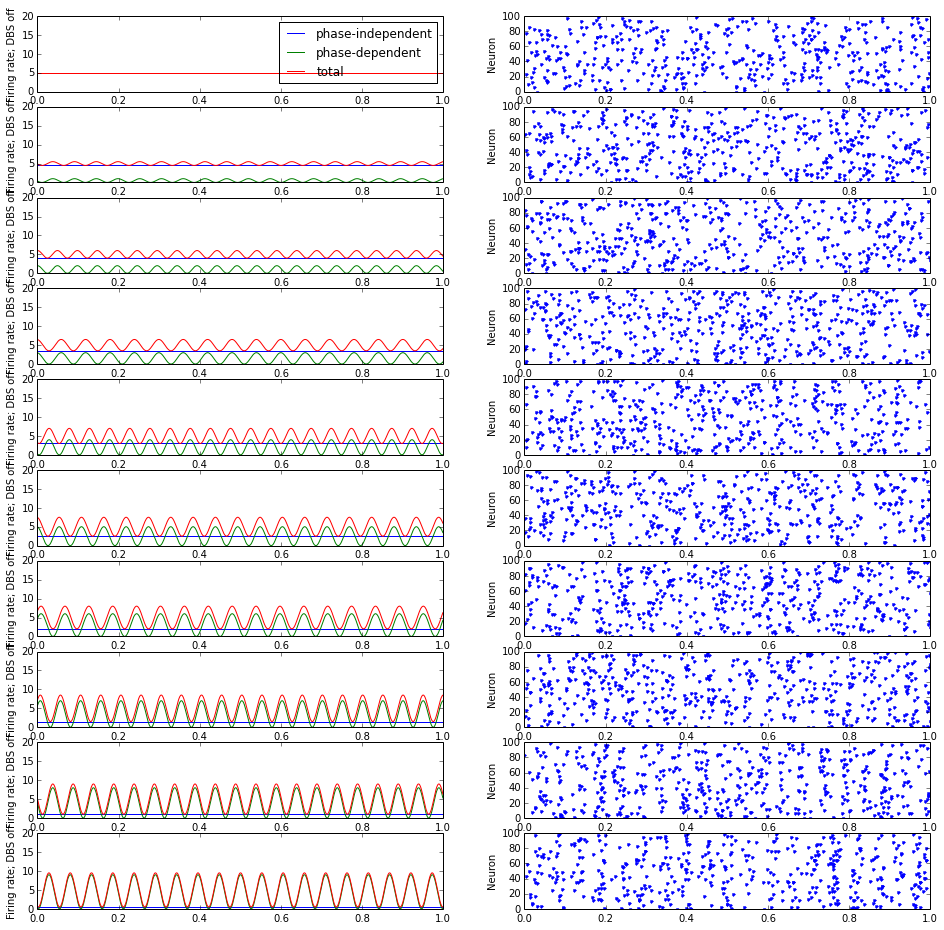

In [4]:
np.random.seed(1)
stg = stgen.StGen()
mod_frac = np.arange(0,1,.1) #Phase-dependent modulation is this fraction of spikes
mod_f_mu = 20.0 #Mean modulation frequency
mod_f_std = 2.0 #StDev of modulation frequency
firing_rate = np.arange(1,11,2) #Firing rate for each neuron in Hz
dt = .001
nNeu = 100.0

E = len(mod_frac)
FR = len(firing_rate)
Tepochs = 10
t_plot = np.arange(0,Tepochs,dt)

spikes = np.zeros([E,FR],dtype=object)
neus = np.zeros([E,FR],dtype=object)
off_dep = np.zeros([E,FR],dtype=object)
off_indep = np.zeros([E,FR],dtype=object)
off_r = np.zeros([E,FR],dtype=object)
plt.figure(figsize = (16,16))
for e in range(E):
    for fr in range(FR):
        thal_phase0 = 2*np.pi*np.random.rand()
        thal_freq = mod_f_mu + mod_f_std*np.random.randn()
        thal_phase = (np.arange(0,Tepochs,dt) % (1/thal_freq)) * 2*np.pi*thal_freq
        thal_phase = (thal_phase + thal_phase0) % (2*np.pi)

        off_dep[e][fr] = np.sin(thal_phase) + 1
        off_dep[e][fr] = off_dep[e][fr] * firing_rate[fr] * mod_frac[e]
        off_indep[e][fr] = firing_rate[fr]*(1-mod_frac[e]) * np.ones(Tepochs/dt)
        off_r[e][fr] = off_dep[e][fr] + off_indep[e][fr] 

        spikes[e][fr] = stg.inh_poisson_generator(off_r[e][fr]*nNeu/dt,np.arange(0,Tepochs,dt),Tepochs,array=True)
        neus[e][fr] = np.random.randint(0,nNeu,len(spikes[e][fr]))
    
    plt.subplot(E,2,2*e+1)
    plt.plot(t_plot[:1000],off_indep[e][2][:1000],label='phase-independent')
    plt.plot(t_plot[:1000],off_dep[e][2][:1000],label='phase-dependent')
    plt.plot(t_plot[:1000],off_r[e][2][:1000],label='total')
    plt.ylabel('Firing rate; DBS off')
    plt.ylim([0,20])
    if e == 0:
        plt.legend()
    
    plt.subplot(E,2,2*e+2)
    plt.plot(spikes[e][2][spikes[e][2]<1],neus[e][2][spikes[e][2]<1],'.')
    plt.ylabel('Neuron')

Calculate LFP

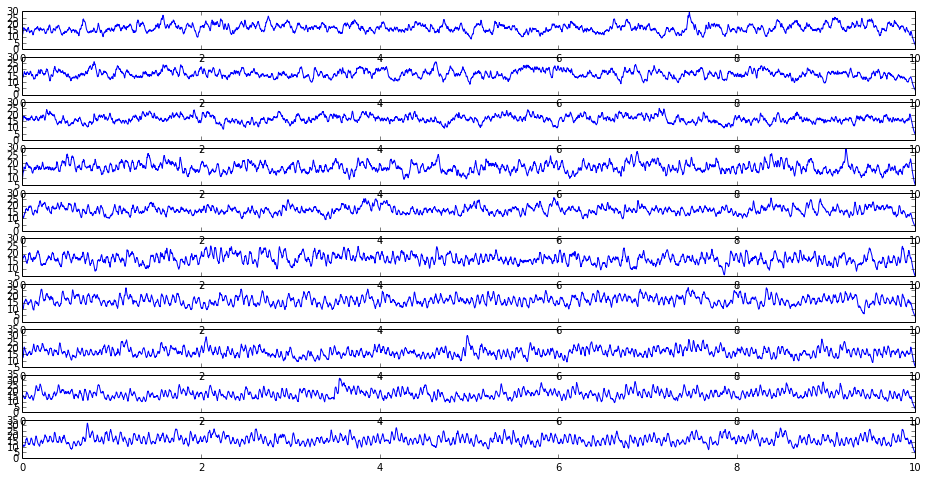

In [5]:
# Define alpha function
t_alpha = np.arange(np.int(100*dt*1000)) # Alpha time course (ms)
tau_rise = 3
tau_decay = 40
gmax = 1
alpha = gmax * (np.exp(-t_alpha/tau_decay) - np.exp(-t_alpha/tau_rise))

# Convert list of spike times to a temporal array 
lfp = np.zeros([E,FR],dtype=object)
plt.figure(figsize = (16,8))
for e in range(E):
    for fr in range(FR):
        splist, t = np.histogram(spikes[e][fr],np.arange(0,Tepochs,dt))
        lfp[e][fr] = np.convolve(splist,alpha,mode='same')
    plt.subplot(E,1,e+1)
    plt.plot(t[:-1],lfp[e][2])

Calculate PAC

In [7]:
Fs = 1/dt
f_hi = [80, 200]
cf = mod_f_mu
beta_hw = 6
f_lo = (cf - beta_hw, cf + beta_hw)
kwargs = {'w_lo' : 7, 'filt_method' : 'fir'}

pac_plv = np.zeros([FR,E])
pac_mi = np.zeros([FR,E])
pac_glm = np.zeros([FR,E])
pac_tort = np.zeros([FR,E])
for e in xrange(E):
    for fr in range(FR):
        pac_plv[fr][e] = plv(lfp[e][fr],lfp[e][fr], f_lo, f_hi)
        pac_tort[fr][e] = mi_tort(lfp[e][fr],lfp[e][fr], f_lo, f_hi)
        pac_mi[fr][e] = mi_canolty(lfp[e][fr],lfp[e][fr], f_lo, f_hi)
        pac_glm[fr][e] = glm(lfp[e][fr],lfp[e][fr], f_lo, f_hi)

Visualize relationship between firing bias and each metric

(-0.1, 1.1)

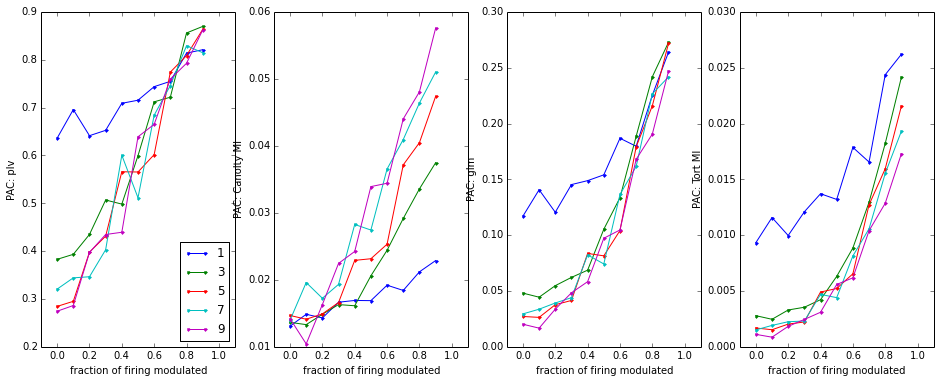

In [11]:
plt.figure(figsize=(16,6))
plt.subplot(1,4,1)
for fr in range(FR):
    plt.plot(mod_frac,pac_plv[fr],'.-',label=np.str(firing_rate[fr]))
plt.xlabel('fraction of firing modulated')
plt.ylabel('PAC: plv')
plt.xlim([-.1,1.1])
plt.legend(loc='best')

plt.subplot(1,4,2)
for fr in range(FR):
    plt.plot(mod_frac,pac_mi[fr],'.-',label=np.str(firing_rate[fr]))
plt.xlabel('fraction of firing modulated')
plt.ylabel('PAC: Canolty MI')
plt.xlim([-.1,1.1])

plt.subplot(1,4,3)
for fr in range(FR):
    plt.plot(mod_frac,pac_glm[fr],'.-',label=np.str(firing_rate[fr]))
plt.xlabel('fraction of firing modulated')
plt.ylabel('PAC: glm')
plt.xlim([-.1,1.1])

plt.subplot(1,4,4)
for fr in range(FR):
    plt.plot(mod_frac,pac_tort[fr],'.-',label=np.str(firing_rate[fr]))
plt.xlabel('fraction of firing modulated')
plt.ylabel('PAC: Tort MI')
plt.xlim([-.1,1.1])

Legend indicates firing rate (Hz) of neurons